In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from scipy.stats import linregress

In [2]:
stock1 = 'EWA'
stock2 = 'EWC'

stocks = [stock1, stock2]

In [3]:
start_date = '2006-04-26'
end_date = '2012-04-09'

In [4]:
# download dos dados
stock_df = yf.download(stocks, start = start_date, end = end_date)['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [5]:
stock_df

,EWA,EWC
Date,,
2006-04-26,10.541416,18.149834
2006-04-27,10.483758,18.025774
2006-04-28,10.541416,18.142538
2006-05-01,10.642313,18.222813
2006-05-02,10.632703,18.419861
...,...,...
2012-03-30,14.834852,22.830433
2012-04-02,14.910571,23.201004
2012-04-03,14.677103,22.854601


In [6]:
S1 = stock_df[stock1]
S2 = stock_df[stock2]

score, pvalue, _ = coint(S1, S2, maxlag=1)
pvalue

0.02129401637486431

Evaluate the spread from two series
* we use a linear regression to get the coefficient for the linear combination to construct between our two securities
* Engle-Granger method

In [7]:
sm.add_constant(S1)

,const,EWA
Date,,
2006-04-26,1.0,10.541416
2006-04-27,1.0,10.483758
2006-04-28,1.0,10.541416
2006-05-01,1.0,10.642313
2006-05-02,1.0,10.632703
...,...,...
2012-03-30,1.0,14.834852
2012-04-02,1.0,14.910571
2012-04-03,1.0,14.677103


$ S2 = spread + hedge ratio * S1$

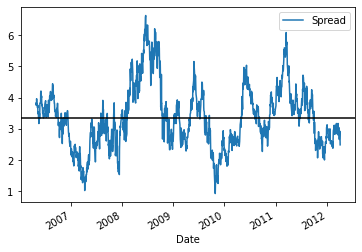

In [8]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1[stock1]
b = results.params[stock1]

# slope, intercept, r, p, se = linregress(stock_df[stock1], stock_df[stock2])
# b = slope
spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

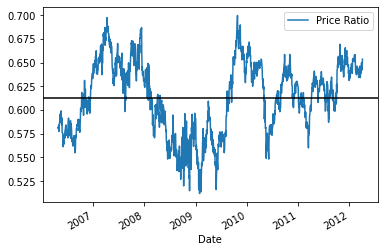

In [9]:
# Alternatively, we could examine the ratio betwen the two series.
ratio = S1/S2
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio']);

The absolute spread isn't very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score.

In [10]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

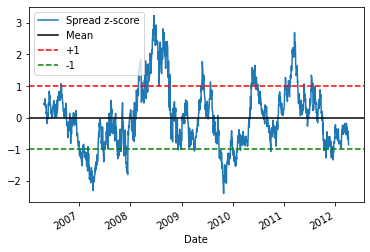

In [11]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

* Going Long the Spread

This is when the spread is small and we expect it to become larger. We place a bet on this by longing Y and shorting X.

* Going Short the Spread

This is when the spread is large and we expect it to become smaller. We place a bet on this by shorting Y and longing X.



Simple Strategy:

* Go "Long" the spread whenever the z-score is below -1.0
* Go "Short" the spread when the z-score is above 1.0
* Exit positions when the z-score approaches zero

This is just the tip of the iceberg, and only a very simplistic example to illustrate the concepts. In practice you would want to compute a more optimal weighting for how many shares to hold for S1 and S2. 

## Trading Strategy

In [12]:
def trading_strategy(spread, hedge_ratio):
    entryZscore = 1
    exitZscore = 0
    stock_df['spread'] = spread
    stock_df['hr'] = hedge_ratio
    stock_df['zScore'] = (stock_df['spread'] - stock_df['spread'].mean()) / stock_df['spread'].std()
    
    stock_df['long_entry'] = ((stock_df.zScore < - entryZscore) & ( stock_df.zScore.shift(1) > - entryZscore))
    stock_df['long_exit'] = ((stock_df.zScore > - exitZscore) & (stock_df.zScore.shift(1) < - exitZscore))
    stock_df['num_units_long'] = np.nan 
    stock_df.loc[stock_df['long_entry'],'num_units_long'] = 1 
    stock_df.loc[stock_df['long_exit'],'num_units_long'] = 0 
    stock_df['num_units_long'][0] = 0 
    stock_df['num_units_long'] = stock_df['num_units_long'].fillna(method='pad')

    stock_df['short_entry'] = ((stock_df.zScore > entryZscore) & ( stock_df.zScore.shift(1) < entryZscore))
    stock_df['short_exit'] = ((stock_df.zScore < exitZscore) & (stock_df.zScore.shift(1) > exitZscore))
    stock_df['num_units_short'] = np.nan 
    stock_df.loc[stock_df['short_entry'],'num_units_short'] = -1
    stock_df.loc[stock_df['short_exit'],'num_units_short'] = 0
    stock_df['num_units_short'][0] = 0
    stock_df['num_units_short'] = stock_df['num_units_short'].fillna(method='pad')

    stock_df['numUnits'] = stock_df['num_units_long'] + stock_df['num_units_short']
    
    #set up totals: num units and returns
    stock_df['spread_pct_ch'] = (stock_df['spread'] - stock_df['spread'].shift(1)) / ((stock_df[stock1] * abs(stock_df['hr'])) + stock_df[stock2])
    stock_df['port_rets'] = stock_df['spread_pct_ch'] * stock_df['numUnits'].shift(1)
    stock_df['cum_rets'] = stock_df['port_rets'].cumsum() + 1

    return(stock_df)

In [13]:
stock_df = trading_strategy(spread, b)

/var/folders/kd/wgbr6mqj4v1bpv6n6fvs2hf40000gn/T/ipykernel_3695/1447052723.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['num_units_long'][0] = 0
/var/folders/kd/wgbr6mqj4v1bpv6n6fvs2hf40000gn/T/ipykernel_3695/1447052723.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['num_units_short'][0] = 0


<AxesSubplot:xlabel='Date'>

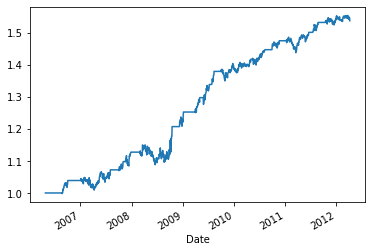

In [14]:
stock_df.cum_rets.plot()

## Trading using constantly updating statistics


In general taking a statistic over your whole sample size can be bad. For example, if the market is moving up, and both securities with it, then your average price over the last 3 years may not be representative of today. For this reason traders often use statistics that rely on rolling windows of the most recent data.

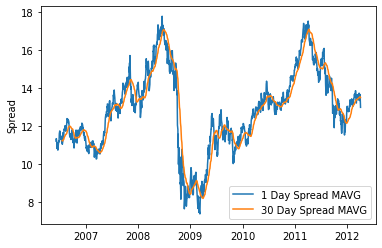

In [15]:
# Get the spread between the 2 stocks
# Calculate rolling beta coefficient
window = 30
rolling_beta = [np.nan] * window
for n in range(window, len(S1)):
    y = S1[(n - window):n]
    X = S2[(n - window):n]
    rolling_beta.append(sm.OLS(y, X).fit().params[0])

rolling_beta = pd.Series(rolling_beta, index=S2.index)

spread = S2 - rolling_beta * S1
spread.name = 'spread'

# Get the 1 day moving average of the price spread
spread_mavg1 = spread.rolling(window=1).mean()
spread_mavg1.name = 'spread 1d mavg'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(30).mean()
spread_mavg30.name = 'spread 30d mavg'

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

plt.ylabel('Spread');

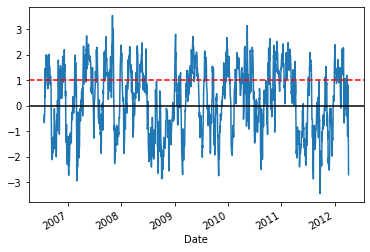

In [16]:
# Take a rolling 30 day standard deviation
std_30 = spread.rolling(30).std()
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
zscore_30_1.name = 'z-score'
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--');

In [17]:
stock_df = trading_strategy(spread_mavg30, rolling_beta)

/var/folders/kd/wgbr6mqj4v1bpv6n6fvs2hf40000gn/T/ipykernel_3695/1447052723.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['num_units_long'][0] = 0
/var/folders/kd/wgbr6mqj4v1bpv6n6fvs2hf40000gn/T/ipykernel_3695/1447052723.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['num_units_short'][0] = 0


<AxesSubplot:xlabel='Date'>

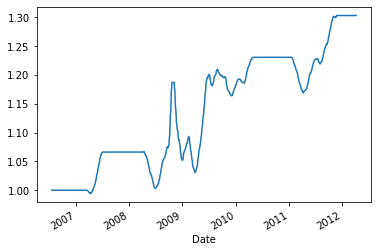

In [18]:
stock_df.cum_rets.plot()

based on https://www.quantrocket.com/codeload/quant-finance-lectures/quant_finance_lectures/Lecture42-Introduction-to-Pairs-Trading.ipynb.html